<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/Copy_of_Mercury_Graphene_Sheet_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and compile LAMMPS


In [1]:
# Install dependencies and compile LAMMPS
%%capture
!apt-get update
!apt-get install -y build-essential cmake libfftw3-dev libjpeg-dev libpng-dev \
                    libopenmpi-dev openmpi-bin python3-dev python3-numpy git
# Clone the LAMMPS repository
%cd /content
!git clone -b stable https://github.com/lammps/lammps.git
%cd lammps

# Create a build directory and compile LAMMPS with required packages
!mkdir build
%cd build
!cmake ../cmake -DBUILD_SHARED_LIBS=yes \
                -DLAMMPS_EXCEPTIONS=yes \
                -DPKG_MOLECULE=yes \
                -DPKG_KSPACE=yes \
                -DPKG_RIGID=yes \
                -DPKG_MANYBODY=yes \
                -DPKG_USER-MISC=yes \
                -DPKG_PYTHON=yes \
                -DPYTHON_EXECUTABLE=`which python3`
!make -j4
!make install-python

# Return to the working directory
%cd /content/

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

#Import Python Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.constants import Avogadro

!pip install MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


# Utility functions for building the system


In [40]:
# Cell 3: Utility functions (with modifications for loading graphene and making pores)
def shift_positions(positions, shift_vector):
    return (np.array(positions) + np.array(shift_vector)).tolist()

def generate_random_position_box(box_bounds, existing_positions, min_distance=2.5, tolerance=0.1):
    max_attempts = 1000
    xlo, xhi, ylo, yhi, zlo, zhi = box_bounds
    for _ in range(max_attempts):
        x = np.random.uniform(xlo, xhi)
        y = np.random.uniform(ylo, yhi)
        z = np.random.uniform(zlo, zhi)
        pos = np.array([x, y, z])

        if existing_positions.size == 0:
            return pos
        distances = np.linalg.norm(existing_positions - pos, axis=1)
        if np.all(distances >= (min_distance - tolerance)):
            return pos
    return None

def place_sorbate(pos, orientation, bond_length=0.9572, bond_angle=104.52):
    theta, phi = orientation
    angle_rad = np.deg2rad(bond_angle / 2)
    x_offset = bond_length * np.sin(angle_rad) * np.cos(phi)
    y_offset = bond_length * np.sin(angle_rad) * np.sin(phi)
    z_offset = bond_length * np.cos(angle_rad)
    H1 = pos + np.array([x_offset, y_offset, z_offset])
    H2 = pos + np.array([-x_offset, -y_offset, z_offset])
    return H1, H2

def create_water_molecules(num_water, box_bounds, existing_positions, min_distance_O=2.5, min_distance_H=1.5):
    water_positions = []
    bond_length = 0.9572
    bond_angle = 104.52

    for i in range(num_water):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        orientation = (theta, phi)

        O = generate_random_position_box(box_bounds, existing_positions, min_distance=min_distance_O)
        if O is None:
            continue
        H1, H2 = place_sorbate(O, orientation, bond_length, bond_angle)
        xlo, xhi, ylo, yhi, zlo, zhi = box_bounds

        if not (xlo <= H1[0] <= xhi and ylo <= H1[1] <= yhi and zlo <= H1[2] <= zhi and
                xlo <= H2[0] <= xhi and ylo <= H2[1] <= yhi and zlo <= H2[2] <= zhi):
            continue

        if existing_positions.size > 0:
            distances_O = np.linalg.norm(existing_positions - O, axis=1)
            distances_H1 = np.linalg.norm(existing_positions - H1, axis=1)
            distances_H2 = np.linalg.norm(existing_positions - H2, axis=1)
        else:
            distances_O = distances_H1 = distances_H2 = np.array([])

        if ((existing_positions.size == 0) or
            (np.all(distances_O >= min_distance_O) and
             np.all(distances_H1 >= min_distance_H) and
             np.all(distances_H2 >= min_distance_H))):
            water_positions.append((O, H1, H2))
            existing_positions = np.vstack([existing_positions, O, H1, H2])

    return water_positions, existing_positions

def add_cations(num_Mg, num_Zn, num_Ca, box_bounds, existing_positions):
    cations = {'Mg': (6, 2.0, num_Mg),
               'Zn': (7, 2.0, num_Zn),
               'Ca': (8, 2.0, num_Ca)}
    added_cations = []

    for ion, (type_id, charge, ion_count) in cations.items():
        for _ in range(ion_count):
            pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
            if pos is not None:
                added_cations.append((type_id, charge, pos))
                existing_positions = np.vstack([existing_positions, pos])
    return added_cations, existing_positions

def calculate_required_cl(total_cations_charge):
    return int(round(total_cations_charge))


def load_and_process_graphene(filename, pore_radius=10.0, num_pores=4):
    """
    Load a pre-existing graphene structure from a file, introduce multiple pores, and return carbon_positions, bonds, etc.
    """
    u = mda.Universe(filename)
    carbons = u.select_atoms('name C')  # Adjust if needed
    positions = carbons.positions.copy()

    # Determine bounding box
    minmax = np.array([positions.min(axis=0), positions.max(axis=0)])
    xlo, ylo, zlo = minmax[0]
    xhi, yhi, zhi = minmax[1]

    # Decide pore positions on a grid
    nx = int(np.sqrt(num_pores))
    ny = int(np.sqrt(num_pores))
    if nx*ny < num_pores:
        ny = nx
        if nx*ny < num_pores:
            ny += 1

    pore_positions = []
    x_range = xhi - xlo
    y_range = yhi - ylo
    dx = x_range/(nx+1)
    dy = y_range/(ny+1)

    count = 0
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            if count >= num_pores:
                break
            pore_x = xlo + i*dx
            pore_y = ylo + j*dy
            pore_positions.append((pore_x, pore_y))
            count += 1
        if count >= num_pores:
            break

    keep_mask = np.ones(len(positions), dtype=bool)
    for (px, py) in pore_positions:
        dist2 = (positions[:,0]-px)**2 + (positions[:,1]-py)**2
        remove_mask = dist2 < pore_radius**2
        keep_mask &= (~remove_mask)

    positions = positions[keep_mask]

    # Re-derive bonds
    a = 2.46
    cutoff_distance = 1.5 * a
    positions_2d = positions[:, :2]
    tree = cKDTree(positions_2d)
    potential_pairs = list(tree.query_pairs(r=cutoff_distance))
    potential_pairs_sorted = sorted(potential_pairs, key=lambda pair: np.linalg.norm(positions_2d[pair[0]] - positions_2d[pair[1]]))

    bond_counts = np.zeros(len(positions), dtype=int)
    carbon_bonds = []
    bond_id = 1
    for idx1, idx2 in potential_pairs_sorted:
        if bond_counts[idx1] < 3 and bond_counts[idx2] < 3:
            carbon_bonds.append((bond_id, 1, idx1+1, idx2+1))
            bond_id += 1
            bond_counts[idx1] += 1
            bond_counts[idx2] += 1

    carbon_angles = []
    return positions.tolist(), carbon_bonds, carbon_angles, (xlo, xhi, ylo, yhi, zlo, zhi)


# Function to create a data file with a given number of Hg ions and functional placement


In [41]:
def create_data_file_from_loaded_graphene(filename, num_Hg=100, pore_radius=10.0, num_pores=10, scale_factor=1.5):
    """
    Load a pre-existing graphene structure from a file, introduce multiple pores, scale the simulation box, and add atoms.

    Args:
        filename (str): Path to the graphene PDB file.
        num_Hg (int): Number of Hg ions to add.
        pore_radius (float): Radius of each pore in angstroms.
        num_pores (int): Number of pores to introduce.
        scale_factor (float): Factor by which to scale the simulation box.

    Returns:
        None
    """
    np.random.seed(42)

    # Load and process graphene
    carbon_positions, carbon_bonds, carbon_angles, original_bounds = load_and_process_graphene(
        filename=filename,
        pore_radius=pore_radius,
        num_pores=num_pores
    )

    xlo, xhi, ylo, yhi, zlo, zhi = original_bounds

    # Calculate original graphene area
    original_area = (xhi - xlo) * (yhi - ylo)

    # Compute new box dimensions based on the scale factor
    x_center = 0.5 * (xlo + xhi)
    y_center = 0.5 * (ylo + yhi)
    z_center = 0.5 * (zlo + zhi)
    half_x = 0.5 * (xhi - xlo) * scale_factor
    half_y = 0.5 * (yhi - ylo) * scale_factor
    half_z = 50.0  # Fixed z-dimension for the simulation box

    xlo_new, xhi_new = x_center - half_x, x_center + half_x
    ylo_new, yhi_new = y_center - half_y, y_center + half_y
    zlo_new, zhi_new = z_center - half_z, z_center + half_z
    box_bounds = (xlo_new, xhi_new, ylo_new, yhi_new, zlo_new, zhi_new)

    # Shift carbon positions to center the graphene within the new box
    shift_vec = [x_center - (xlo + xhi) / 2.0, y_center - (ylo + yhi) / 2.0, z_center - (zlo + zhi) / 2.0]
    carbon_positions = shift_positions(carbon_positions, shift_vec)

    # Define atom types and charges
    atom_types = {
        'C': 1,
        'O': 2,
        'H': 3,
        'Hg':4,
        'Cl':5,
        'Mg':6,
        'Zn':7,
        'Ca':8
    }

    charges = {
        1: 0.0,      # C
        2: -0.834,   # O
        3: 0.417,    # H
        4: 2.0,      # Hg
        5: -1.0,     # Cl
        6: 2.0,      # Mg
        7: 2.0,      # Zn
        8: 2.0       # Ca
    }

    atoms = []
    atom_id = 1
    molecule_id = 1
    for pos in carbon_positions:
        atoms.append([atom_id, molecule_id, atom_types['C'], charges[1], pos[0], pos[1], pos[2]])
        atom_id += 1

    carbon_positions_arr = np.array(carbon_positions)
    distances = np.sqrt((carbon_positions_arr[:,0]-x_center)**2 + (carbon_positions_arr[:,1]-y_center)**2)
    bond_lengths = []
    for bond in carbon_bonds:
        _, _, a1, a2 = bond
        p1 = carbon_positions_arr[a1 - 1]
        p2 = carbon_positions_arr[a2 - 1]
        bl = np.linalg.norm(p1 - p2)
        bond_lengths.append(bl)
    if len(bond_lengths) > 0:
        avg_bond_length = np.mean(bond_lengths)
    else:
        avg_bond_length = 1.42  # Default C-C bond length

    max_distance = np.max(distances)
    num_C_groups = 10
    num_carbonyl = 4
    num_hydroxyl = num_C_groups - num_carbonyl
    edge_threshold = max_distance - (1.5 * avg_bond_length)
    edge_carbon_ids = [i+1 for i, d in enumerate(distances) if d >= edge_threshold]
    if len(edge_carbon_ids) < num_C_groups:
        sorted_ids = np.argsort(distances)[::-1]
        candidates = [idx+1 for idx in sorted_ids if (idx+1) not in edge_carbon_ids]
        needed = num_C_groups - len(edge_carbon_ids)
        edge_carbon_ids.extend(candidates[:needed])

    chosen_carbon_ids = edge_carbon_ids[:num_C_groups]

    bonds = carbon_bonds.copy()
    angles = carbon_angles.copy()
    bond_id = len(bonds) + 1
    angle_id = len(angles) + 1

    # Functional groups
    for idx, c_id in enumerate(chosen_carbon_ids):
        c_pos = carbon_positions_arr[c_id - 1]
        direction = np.array([c_pos[0]-x_center, c_pos[1]-y_center, 0.0])
        norm = np.linalg.norm(direction)
        if norm == 0:
            direction = np.array([1.0, 0.0, 0.0])
        else:
            direction = direction / norm

        if idx < num_carbonyl:
            # Carbonyl
            O_pos = c_pos + direction * 1.2
            atoms.append([atom_id, molecule_id, atom_types['O'], -0.834, O_pos[0], O_pos[1], O_pos[2]])
            O_id = atom_id
            atom_id += 1
            bonds.append((len(bonds)+1, 3, c_id, O_id))
            atoms[c_id - 1][3] += 0.834  # Adjust charge

        else:
            # Hydroxyl
            O_pos = c_pos + direction * 1.2
            atoms.append([atom_id, molecule_id, atom_types['O'], -0.417, O_pos[0], O_pos[1], O_pos[2]])
            O_id = atom_id
            atom_id += 1
            bonds.append((len(bonds)+1, 3, c_id, O_id))

            H_pos = O_pos + np.array([0.96, 0.0, 0.0])  # Adjust orientation as needed
            atoms.append([atom_id, molecule_id, atom_types['H'], 0.417, H_pos[0], H_pos[1], H_pos[2]])
            H_id = atom_id
            atom_id += 1
            bonds.append((len(bonds)+1, 2, O_id, H_id))

        molecule_id += 1

    existing_positions = np.array([[a[4], a[5], a[6]] for a in atoms])

    # Add Hg2+
    added_Hg = []
    for _ in range(num_Hg):
        pos = generate_random_position_box((xlo_new, xhi_new, ylo_new, yhi_new, zlo_new, zhi_new), existing_positions, min_distance=2.5)
        if pos is not None:
            atoms.append([atom_id, molecule_id, atom_types['Hg'], charges[4], pos[0], pos[1], pos[2]])
            atom_id += 1
            molecule_id += 1
            existing_positions = np.vstack([existing_positions, pos])
            added_Hg.append(pos)

    # Add other cations
    num_Mg = int(20 * scale_factor)
    num_Zn = int(20 * scale_factor)
    num_Ca = int(20 * scale_factor)
    added_cations, existing_positions = add_cations(num_Mg, num_Zn, num_Ca, (xlo_new, xhi_new, ylo_new, yhi_new, zlo_new, zhi_new), existing_positions)

    placed_Mg = sum(1 for c in added_cations if c[0] == 6)
    placed_Zn = sum(1 for c in added_cations if c[0] == 7)
    placed_Ca = sum(1 for c in added_cations if c[0] == 8)
    total_cations_charge = placed_Hg * 2.0 + placed_Mg * 2.0 + placed_Zn * 2.0 + placed_Ca * 2.0

    required_cl = calculate_required_cl(total_cations_charge)

    for cat in added_cations:
        type_id, charge, pos_c = cat
        atoms.append([atom_id, molecule_id, type_id, charge, pos_c[0], pos_c[1], pos_c[2]])
        atom_id += 1
        molecule_id += 1

    for i in range(required_cl):
        pos = generate_random_position_box((xlo_new, xhi_new, ylo_new, yhi_new, zlo_new, zhi_new), existing_positions, min_distance=2.5)
        if pos is not None:
            atoms.append([atom_id, molecule_id, atom_types['Cl'], charges[5], pos[0], pos[1], pos[2]])
            atom_id += 1
            molecule_id += 1
            existing_positions = np.vstack([existing_positions, pos])

    # Add water molecules
    num_H2O = int(500 * scale_factor)
    water_molecules, existing_positions = create_water_molecules(num_H2O, (xlo_new, xhi_new, ylo_new, yhi_new, zlo_new, zhi_new), existing_positions)
    bond_id = len(bonds) + 1
    angle_id = len(angles) + 1
    for water in water_molecules:
        O, H1, H2 = water
        molecule_id += 1
        atoms.append([atom_id, molecule_id, atom_types['O'], -0.834, O[0], O[1], O[2]])
        O_id = atom_id
        atom_id += 1
        atoms.append([atom_id, molecule_id, atom_types['H'], 0.417, H1[0], H1[1], H1[2]])
        H1_id = atom_id
        atom_id += 1
        atoms.append([atom_id, molecule_id, atom_types['H'], 0.417, H2[0], H2[1], H2[2]])
        H2_id = atom_id
        atom_id += 1

        bonds.append((bond_id, 2, O_id, H1_id))
        bond_id += 1
        bonds.append((bond_id, 2, O_id, H2_id))
        bond_id += 1
        angles.append((angle_id, 2, H1_id, O_id, H2_id))
        angle_id += 1

    num_atoms = len(atoms)
    num_bonds = len(bonds)
    num_angles = len(angles)

    total_charge = sum(a[3] for a in atoms)
    if abs(total_charge) > 0.001:
        print(f"Warning: System not neutral. Total charge = {total_charge:.4f}")

    num_bond_types = 3
    num_angle_types = 2

    data_file = f"data_{num_Hg}.lmp"
    with open(data_file, 'w') as f:
        f.write("# LAMMPS data file with pores and scaled box\n\n")
        f.write(f"{num_atoms} atoms\n")
        f.write("8 atom types\n")
        f.write(f"{num_bonds} bonds\n")
        f.write(f"{num_bond_types} bond types\n")
        f.write(f"{num_angles} angles\n")
        f.write(f"{num_angle_types} angle types\n\n")

        f.write(f"{xlo_new} {xhi_new} xlo xhi\n")
        f.write(f"{ylo_new} {yhi_new} ylo yhi\n")
        f.write(f"{zlo_new} {zhi_new} zlo zhi\n\n")

        f.write("Masses\n\n")
        f.write("1 12.011 # C\n")
        f.write("2 15.9994 # O\n")
        f.write("3 1.008 # H\n")
        f.write("4 200.59 # Hg\n")
        f.write("5 35.453 # Cl\n")
        f.write("6 24.305 # Mg\n")
        f.write("7 65.38 # Zn\n")
        f.write("8 40.078 # Ca\n\n")

        f.write("Atoms # full\n\n")
        for atom in atoms:
            f.write(f"{atom[0]} {atom[1]} {atom[2]} {atom[3]:.4f} {atom[4]:.4f} {atom[5]:.4f} {atom[6]:.4f}\n")

        f.write("\nBonds\n\n")
        for bond in bonds:
            f.write(f"{bond[0]} {bond[1]} {bond[2]} {bond[3]}\n")

        if len(angles) > 0:
            f.write("\nAngles\n\n")
            for angle in angles:
                f.write(f"{angle[0]} {angle[1]} {angle[2]} {angle[3]} {angle[4]}\n")

    print(f"Data file '{data_file}' generated successfully with {num_atoms} atoms. Total charge = {total_charge:.4f}")


# Function to analyze simulation results


In [42]:
# Cell 5: Create input script and run LAMMPS simulation per Hg_num
def setup_and_run_sim(num_Hg):
    data_file = f"data_{num_Hg}.lmp"
    input_script = f"""
units           real
atom_style      full
boundary        p p p
read_data       {data_file}

pair_style      lj/cut/coul/long 10.0 10.0
kspace_style    pppm 1.0e-6
pair_coeff      * * 0.1 3.0

bond_style      harmonic
bond_coeff      1 450.0 1.42
bond_coeff      2 450.0 0.9572
bond_coeff      3 450.0 1.43

angle_style     harmonic
angle_coeff     1 55.0 120.0
angle_coeff     2 55.0 104.52

group           carbon type 1
fix             fix_carbon carbon setforce 0.0 0.0 0.0

neighbor        2.0 bin
neigh_modify    delay 0 every 1 check yes

velocity        all create 300.0 12345 mom yes rot yes dist gaussian
fix             1 all shake 0.0001 20 0 a 1
fix             nvt_control all nvt temp 300.0 300.0 100.0

thermo          1000
thermo_style    custom step temp etotal press
dump            1 all atom 100 dump_{num_Hg}.lammpstrj
run             2000
"""
    in_file = f"in_{num_Hg}.lmp"
    with open(in_file, 'w') as f:
        f.write(input_script)

    ! /content/lammps/build/lmp -in {in_file}


# Function to analyze simulation results


In [43]:
# Cell 6: analyze_simulation function and run multiple Hg concentrations
def analyze_simulation(num_Hg=50, box_dims=(150.0,150.0,100.0), mass_adsorbent=1.0, initial_counts=None):
    # initial_counts should reflect what we started with for that simulation
    # Let's assume initial_counts={'Hg': num_Hg,'Mg':20,'Zn':20,'Ca':20} as per above code
    if initial_counts is None:
        initial_counts = {'Hg':num_Hg,'Mg':20,'Zn':20,'Ca':20}
    data_file = f"data_{num_Hg}.lmp"
    dump_file = f"dump_{num_Hg}.lammpstrj"
    u = mda.Universe(
        topology=data_file,
        trajectory=dump_file,
        topology_format='DATA',
        trajectory_format='LAMMPSDUMP'
    )

    ref_group = u.select_atoms('type 1') # Carbon
    target_group = u.select_atoms('type 4') # Hg

    r_min, r_max = 0.0, 10.0
    rdf_calc = InterRDF(ref_group, target_group, range=(r_min, r_max), nbins=100)
    rdf_calc.run()

    r = rdf_calc.bins
    rdf = rdf_calc.rdf

    peaks, _ = find_peaks(rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted_rdf = -rdf
        minima, _ = find_peaks(inverted_rdf, distance=10)
        cutoff_candidates = minima[minima > first_peak]
        if len(cutoff_candidates) > 0:
            r_cut = r[cutoff_candidates[0]]
        else:
            r_cut = r_max
    else:
        r_cut = r_max

    adsorbed_Hg = 0
    total_frames = 0
    for ts in u.trajectory:
        positions_ref = ref_group.positions
        positions_target = target_group.positions
        tree_ref = cKDTree(positions_ref)
        tree_target = cKDTree(positions_target)
        sparse_dist_matrix = tree_ref.sparse_distance_matrix(tree_target, max_distance=r_cut, output_type='coo_matrix')
        adsorbed_indices = np.unique(sparse_dist_matrix.col)
        adsorbed_Hg += len(adsorbed_indices)
        total_frames += 1

    if total_frames > 0:
        avg_adsorbed = adsorbed_Hg / total_frames
    else:
        avg_adsorbed = 0.0

    MW_Hg = 200.59
    q_e = (avg_adsorbed * MW_Hg) / mass_adsorbent * 1000.0 # mg/g

    volume_A3 = box_dims[0]*box_dims[1]*box_dims[2]
    volume_L = volume_A3 * 1e-24
    N_initial = initial_counts['Hg']
    N_unads = N_initial - avg_adsorbed
    C_e = (N_unads * MW_Hg / Avogadro) / volume_L * 1e3  # mg/L

    return C_e, q_e, r, rdf, r_cut


# Run simulations at different Hg concentrations and analyze


LAMMPS (29 Aug 2024 - Update 1)
  using 4 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (100 100 35)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  934 atoms
  scanning bonds ...
  3 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (100 100 35)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  852 bonds
  reading angles ...
  97 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     4 = max # of 1-2 neighbors
     9 = max # of 1-3 neighbors
    25 = max # of 1-4 neighbors
    18 = max # of special neighbors
  special bonds CPU = 0.001 seconds
  read_data CPU = 0.017 seconds
477 atoms in group carbon
Finding SHAKE clusters ...
       0 = # of size 2 clusters
       0 = # of size 3 clusters
       0 = # of size 4 clusters
       0 = # of frozen angles
  find clusters CPU = 0.000 seconds

CITE-CI

/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/base.py:522: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/rdf.py:339: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/rdf.py:347: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


LAMMPS (29 Aug 2024 - Update 1)
  using 4 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (100 100 35)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  994 atoms
  scanning bonds ...
  3 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (100 100 35)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  852 bonds
  reading angles ...
  97 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     4 = max # of 1-2 neighbors
     9 = max # of 1-3 neighbors
    25 = max # of 1-4 neighbors
    18 = max # of special neighbors
  special bonds CPU = 0.001 seconds
  read_data CPU = 0.011 seconds
477 atoms in group carbon
Finding SHAKE clusters ...
       0 = # of size 2 clusters
       0 = # of size 3 clusters
       0 = # of size 4 clusters
       0 = # of frozen angles
  find clusters CPU = 0.000 seconds

CITE-CI

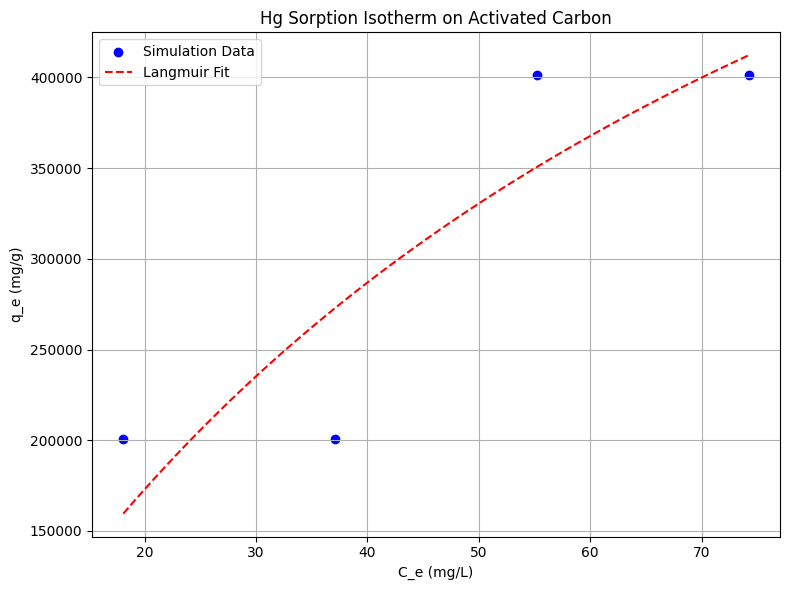

Langmuir fit parameters:
q_max = 841636.61 mg/g, K_L = 0.0129 L/mg


In [45]:
Hg_counts = [20, 40, 60, 80]  # representing 2nM,4nM,6nM,8nM (arbitrary scale)
Ce_values = []
qe_values = []

for Hg_num in Hg_counts:
    setup_and_run_sim(Hg_num)
    Ce, qe, r, rdf, r_cut = analyze_simulation(Hg_num, box_dims=(100.0,100.0,35.0), initial_counts={'Hg':Hg_num,'Mg':10,'Zn':10,'Ca':10})
    Ce_values.append(Ce)
    qe_values.append(qe)

# Fit a Langmuir isotherm
def langmuir(C, q_max, K_L):
    return (q_max*K_L*C)/(1+K_L*C)

params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1])
Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
qe_fit = langmuir(Ce_fit, *params)

plt.figure(figsize=(8,6))
plt.scatter(Ce_values, qe_values, color='blue', label='Simulation Data')
plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
plt.xlabel('C_e (mg/L)')
plt.ylabel('q_e (mg/g)')
plt.title('Hg Sorption Isotherm on Activated Carbon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Langmuir fit parameters:")
print(f"q_max = {params[0]:.2f} mg/g, K_L = {params[1]:.4f} L/mg")